In [27]:
import os
import json
import time
import random
import requests
import pprint

import numpy as np
import pandas as pd

from PIL import Image
from ipyplot import plot_images
from google.cloud import storage

API_ENDPOINT = f'http://{os.getenv("API_HOST")}:5000'
PROJECT_ID = "tcc-lucas-pierre"
BUCKET_NAME = "tcc-clothes"

In [28]:
performed_tasks = {}


def perform_task(params, endpoint):
    api_response = requests.post(f"{API_ENDPOINT}/{endpoint}", json=params).json()
    print(api_response)
    return api_response
    # task_id = api_response["task_id"]

#     status = "PENDING"
#     print("Processing...")
#     while status == "PENDING":
#         time.sleep(3)
#         response = requests.get(f"{API_ENDPOINT}/task/{task_id}").json()
#         print(response)
#         status = response["status"]

#     performed_tasks[task_id] = {
#         "params": params,
#         "status": status,
#         "result": response["result"],
#     }

#     if status != "SUCCESS":
#         raise Exception(response)
#     else:
#         print("Task complete!")

#     return response["result"]["s3_target"]

In [29]:
from google.cloud import storage
from io import BytesIO
from PIL import Image


def download_blob_into_memory(bucket_name, blob_name):
    """Downloads a blob into memory."""
    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    blob = bucket.blob(blob_name)
    contents = blob.download_as_bytes()

    return contents


def draw_images(items, source_folder, sample=3):
    sample_items = random.sample(items, sample)

    images = []
    for item in sample_items:
        img = download_blob_into_memory(
            bucket_name, f'{source_folder}/{item["image_id"]}.jpg'
        )
        image = np.asarray(Image.open(BytesIO(img)))
        images.append(image)
    plot_images(
        images,
        labels=[item["image_id"] for item in sample_items],
        custom_texts=[pprint.pformat(item) for item in sample_items],
        zoom_scale=1.0,
    )

## Task 1:

Query for men's shoes based on date. 

In [35]:
LIMIT = 10
YEAR = 2012

payload = {
    "gender": "Men", 
    "sub_category": "Shoes", 
    "start_year": YEAR,
    "limit": LIMIT,
}
gcs_target = perform_task(payload, "filter")
print(gcs_target)

# # filter results
# with s3.open(f'{s3_target}/metadata.json') as f:
#     metadata = json.load(f)

# # sample of original images
# draw_images(metadata, f'{s3_target}/images')

{'task_id': '9450222193609633737'}
{'task_id': '9450222193609633737'}


In [12]:
bucket_file = gcs_target + "/metadata.json"
content = download_blob_into_memory(bucket_name, bucket_file)
metadata = json.loads(content)
# sample of original images
draw_images(metadata, f"{gcs_target}/images", sample=1)

TypeError: unsupported operand type(s) for +: 'dict' and 'str'

## Task 2:

Run the same query, but now do augmentation to the images based on the given configuration

In [12]:
payload = {
    "gender": "Women",
    "sub_category": "Bottomwear",
    "start_year": YEAR,
    "limit": LIMIT,
    "augmentation_config": {
        "albumentation": {
            "input_image": {"width": 60, "height": 80},
            "cropping": {"height": {"min": 10, "max": 70}},
            "resize": {"width": 256, "height": 256},
        }
    },
}

s3_target = perform_task(payload, "filter")

{'task_id': '7fcbc982-af6a-4f22-9702-823ab0c81770'}
Processing...
{'id': '7fcbc982-af6a-4f22-9702-823ab0c81770', 'status': 'SUCCESS', 'error': None, 'result': {'s3_target': 'fashion-tasks/7fcbc982-af6a-4f22-9702-823ab0c81770'}}
Task complete!



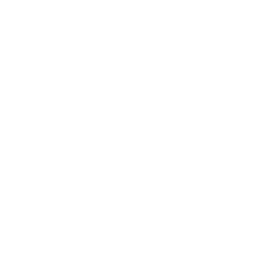


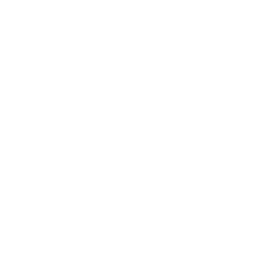

In [13]:
import cv2

bucket_file = s3_target + "/metadata.json"


def draw_images2(items, source_folder, sample=3):
    sample_items = random.sample(items, sample)

    images = []
    for item in sample_items:
        img_encoded = download_blob_into_memory(
            bucket_name, f'{source_folder}/{item["image_id"]}.jpg'
        )
        nparr = np.frombuffer(img_encoded, np.byte)
        image = cv2.imdecode(nparr, cv2.IMREAD_ANYCOLOR)
        images.append(image)
    plot_images(
        images,
        labels=[item["image_id"] for item in sample_items],
        custom_texts=[pprint.pformat(item) for item in sample_items],
        zoom_scale=1.0,
    )


content = download_blob_into_memory(bucket_name, bucket_file)
metadata = json.loads(content)
# sample of original images
draw_images2(metadata, f"{s3_target}/augmentation", sample=1)

## Task 3: 

Run inference using the FashionNetVgg16NoBn from https://github.com/i008/pytorch-deepfashion.git on the original images in Step 1 or 2.

In [14]:
s3_target = perform_task({"s3_target": s3_target}, "predict")

bucket_file = f"{s3_target}/predictions.json"
content = download_blob_into_memory(bucket_name, bucket_file)
predictions = json.loads(content)

print(f"Number of predictions: {len(predictions)}")
print(
    f'Prediction output per image: massive_attr-{len(predictions[0]["massive_attr"][0])}, categories-{len(predictions[0]["categories"][0])}'
)

{'task_id': '632e0c9d-aa31-4246-8b95-143fa9e04fb5'}
Processing...
{'id': '632e0c9d-aa31-4246-8b95-143fa9e04fb5', 'status': 'PENDING', 'error': None, 'result': None}
{'id': '632e0c9d-aa31-4246-8b95-143fa9e04fb5', 'status': 'SUCCESS', 'error': None, 'result': {'s3_target': 'fashion-tasks/7fcbc982-af6a-4f22-9702-823ab0c81770'}}
Task complete!
Number of predictions: 1
Prediction output per image: massive_attr-1000, categories-50
